# Probability distribution using Oscilloscope

C:\Users\dalop\AppData\Local\Temp\ipykernel_10664\644384931.py:8: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, skiprows=20)


       Interval Start  Interval End Classification
0              -0.002        -0.002       1 Photon
1              -0.002        -0.002       1 Photon
2              -0.002        -0.002       1 Photon
3              -0.002        -0.002      0 Photons
4              -0.002        -0.002       1 Photon
...               ...           ...            ...
79994           0.002         0.002       1 Photon
79995           0.002         0.002       1 Photon
79996           0.002         0.002       1 Photon
79997           0.002         0.002      0 Photons
79998           0.002         0.002       1 Photon

[79999 rows x 3 columns]


c:\Users\dalop\OneDrive - stevens.edu\Stevens - PhD Physics\Research\Colaborations\Missagh\PNR\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


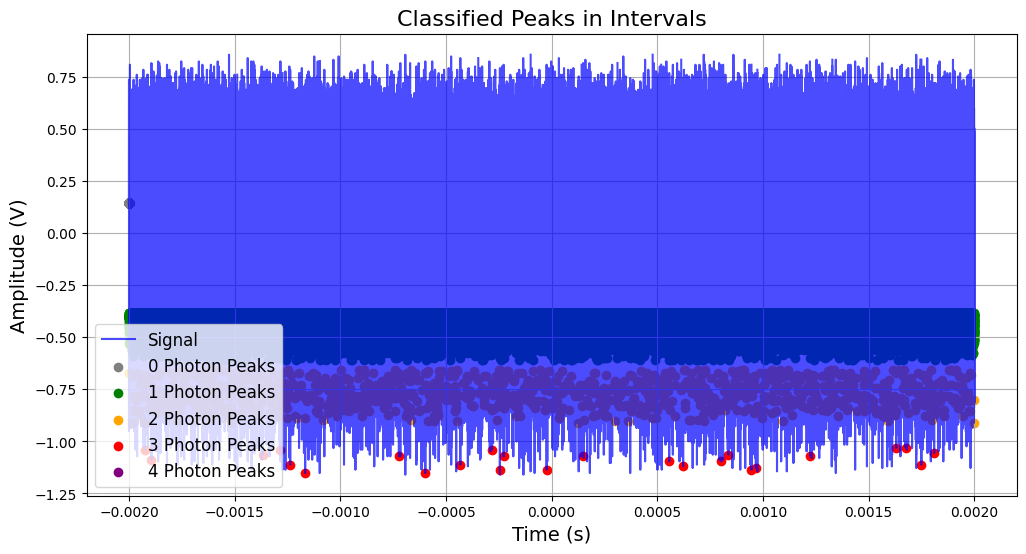

In [17]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

# Load the CSV file (replace with your actual file path)
file_name = 'try1.csv'
file_path = f'data/{file_name}'
df = pd.read_csv(file_path, skiprows=20)

# Rename columns
#df.columns = ['TIME', 'CH2', 'CH3', 'CH4']
df.columns = ['TIME', 'CH4']

# Convert CH4 column to numeric, coercing errors (non-numeric values will be replaced with NaN)
df['CH4'] = pd.to_numeric(df['CH4'], errors='coerce')

# Drop rows with NaN values in CH4
df = df.dropna(subset=['CH4'])

# Extract time and signal data again after cleaning
time = df['TIME']
ch4 = df['CH4']

# Define the interval width
interval_width = 5.0e-08  # Time interval width

# Define photon ranges (in volts)
photon_ranges = {
    '1 Photon': (-0.608, -0.380),
    '2 Photon': (-0.912, -0.656),
    '3 Photon': (-1.23, -1.03),
    '4 Photon': (-1.4, -1.23),
}


# photon_ranges = {
#     '1 Photon': (-0.940, -0.600),
#     '2 Photon': (-1.220, -0.941),
#     '3 Photon': (-1.5, -1.221),
#     '4 Photon': (-1.97, -1.501),
# }


# Classify peaks
classified_peaks = {'0 Photon': [], '1 Photon': [], '2 Photon': [], '3 Photon': [], '4 Photon': []}

# Create bins based on the interval width
time_min, time_max = np.min(time), np.max(time)
bins = np.arange(time_min, time_max, interval_width)

# Find peaks in the signal
peaks, _ = find_peaks(-ch4, height=0.35)

# Initialize lists to store results
classified_intervals = []

# Iterate over each interval
for i in range(len(bins) - 1):
    # Define the start and end of the interval
    start, end = bins[i], bins[i + 1]

    # Get indices of peaks within this interval
    peaks_in_interval = peaks[(time.iloc[peaks] >= start) & (time.iloc[peaks] < end)]

    # Initialize classification for the interval
    interval_classification = {'Interval Start': start, 'Interval End': end, 'Classification': '0 Photons'}

    # Check if there are peaks in the interval
    if len(peaks_in_interval) > 0:
        # Find the highest peak in the interval
        max_peak_idx = peaks_in_interval[np.argmax(ch4.iloc[peaks_in_interval])]
        max_amplitude = ch4.iloc[max_peak_idx]

        # Classify the peak based on photon ranges
        for photon, (lower, upper) in photon_ranges.items():
            if lower <= max_amplitude <= upper:
                interval_classification['Classification'] = photon
                classified_peaks[photon].append(max_peak_idx)
                break  # Stop checking after classification
    else:
        # If no peaks, classify as 0 photons
        interval_classification['Classification'] = '0 Photons'
        classified_peaks['0 Photon'].append(0)

    # Append the interval classification
    classified_intervals.append(interval_classification)

# Convert results to a DataFrame for better visualization
classified_intervals_df = pd.DataFrame(classified_intervals)

# Display results
print(classified_intervals_df)

# Optional: Plot the signal with classified peaks
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(time, ch4, color='blue', alpha=0.7, label='Signal')

# Plot peaks for each photon category
colors = ['gray', 'green', 'orange', 'red', 'purple']
for i, (photon, peak_indices) in enumerate(classified_peaks.items()):
    plt.scatter(time.iloc[peak_indices], ch4.iloc[peak_indices],
                label=f'{photon} Peaks', color=colors[i])

# Plot settings
plt.title('Classified Peaks in Intervals', fontsize=16)
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Amplitude (V)', fontsize=14)
plt.grid(True)
plt.legend(fontsize=12)
plt.show()


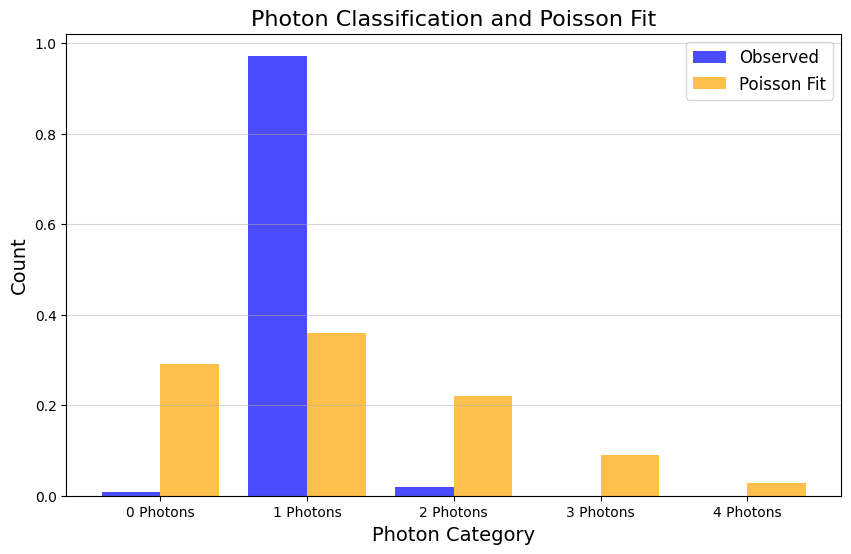

Fitted lambda (mean photon count): 1.231


In [18]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import poisson

# Generate histogram data
photon_counts = {photon: len(indices) for photon, indices in classified_peaks.items()}

# Convert the dictionary to numeric values
categories = np.array([0, 1, 2, 3, 4])  # Numeric photon categories
counts = np.array(list(photon_counts.values())) # Observed counts
total_count = np.sum(counts)  # Total observed count
probabilities = counts/total_count

# Define a function for Poisson fitting
def poisson_scaled(k, lamb):
    """Poisson PMF scaled to match the observed total count."""
    return poisson.pmf(k, lamb)

# Fit the Poisson distribution to the observed counts
popt, _ = curve_fit(poisson_scaled, categories, probabilities , p0=[1])  # Initial guess for lambda=1
fitted_lambda = popt[0]

# Generate the fitted Poisson counts
poisson_fit_counts = poisson_scaled(categories, fitted_lambda)

# Plot the histogram and Poisson fit
plt.figure(figsize=(10, 6))

# Observed counts
plt.bar(categories - 0.2, probabilities , width=0.4, label='Observed', color='blue', alpha=0.7)

# Poisson fit
plt.bar(categories + 0.2, poisson_fit_counts, width=0.4, label='Poisson Fit', color='orange', alpha=0.7)

# Customize the plot
plt.title('Photon Classification and Poisson Fit', fontsize=16)
plt.xlabel('Photon Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(categories, [f'{c} Photons' for c in categories])
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.5)

# Show the plot
plt.show()

# Print the fitted lambda
print(f"Fitted lambda (mean photon count): {fitted_lambda:.3f}")


# Getting the $P$ matrix

In [20]:
# The columns of the P matrix are computed here!
import torch

def P_0m(eta: torch.Tensor, m: int) -> torch.Tensor:
    """
    Computes P_{0m} = (1 - sum_{i=1..N} eta_i)^m in PyTorch.
    
    Parameters
    ----------
    eta : torch.Tensor of shape (N,)
        Nonnegative probabilities or weights.
    m   : int
        Nonnegative integer exponent.

    Returns
    -------
    torch.Tensor (scalar)
        The value of P_{0m}.
    """
    sum_eta = torch.sum(eta)
    return (1.0 - sum_eta) ** m


def P_1m(eta: torch.Tensor, m: int) -> torch.Tensor:
    """
    Computes

        P_{1m} = sum_{gamma=1..m} sum_{|A|=N-1} [
            (1 - sum(eta))^(gamma-1) * sum(eta) * (1 - sum_{j in A}(eta_j))^(m-gamma)
        ] / N

    where the 'sum_{|A|=N-1}' is effectively a sum over all missing indices.
    
    Parameters
    ----------
    eta : torch.Tensor of shape (N,)
    m   : int

    Returns
    -------
    torch.Tensor (scalar)
        The value of P_{1m}.
    """
    N = eta.shape[0]
    sum_eta = torch.sum(eta)

    P = torch.zeros([], dtype=eta.dtype, device=eta.device)
    for gamma1 in range(1, m + 1):
        factor_left = (1.0 - sum_eta) ** (gamma1 - 1)
        # Sum over "missing index" k
        sub_sum = torch.zeros([], dtype=eta.dtype, device=eta.device)
        for k in range(N):
            sub_sum += ((1.0 - sum_eta) + eta[k]) ** (m - gamma1)
        P += factor_left * sum_eta * sub_sum

    return P / N


def P_2m(eta: torch.Tensor, m: int) -> torch.Tensor:
    """
    Computes

        P_{2m} = sum_{1 <= g1 <= g2 <= m} [
            (1 - S)^(g1 - 1) * S
            * { (1/N) * sum_{a=1..N} [
                  (1 - S + eta[a])^(g2 - g1 - 1) * (S - eta[a])
                ] }
            * { (2 / (N*(N-1))) * sum_{b1<b2} [
                  (1 - S + eta[b1] + eta[b2])^(m - g2)
                ] }
        ]

    where S = sum(eta).

    Parameters
    ----------
    eta : torch.Tensor of shape (N,)
    m   : int

    Returns
    -------
    torch.Tensor (scalar)
    """
    N = eta.shape[0]
    S = torch.sum(eta)

    total = torch.zeros([], dtype=eta.dtype, device=eta.device)

    for g1 in range(1, m + 1):
        for g2 in range(g1, m + 1):
            factor_left = (1.0 - S) ** (g1 - 1) * S

            expA = g2 - g1 - 1
            sum_over_A = torch.zeros([], dtype=eta.dtype, device=eta.device)
            for a in range(N):
                baseA = (1.0 - S + eta[a])
                sumA  = (S - eta[a])
                sum_over_A += (baseA ** expA) * sumA
            sum_over_A *= (1.0 / N)

            expB = m - g2
            sum_over_B = torch.zeros([], dtype=eta.dtype, device=eta.device)
            for b1 in range(N):
                for b2 in range(b1 + 1, N):
                    baseB = (1.0 - S + eta[b1] + eta[b2])
                    sum_over_B += (baseB ** expB)
            sum_over_B *= (2.0 / (N * (N - 1)))

            total += factor_left * sum_over_A * sum_over_B

    return total


def P_3m(eta: torch.Tensor, m: int) -> torch.Tensor:
    """
    Computes

        P_{3m} = sum_{1 <= g1 < g2 < g3 <= m} [
            (1 - S)^(g1 - 1) * S
            * { (1/N) * sum_{a} [ ... ] }
            * { (2/(N(N-1))) * sum_{b1<b2} [ ... ] }
            * { (6/(N(N-1)(N-2))) * sum_{c1<c2<c3} [ ... ] }
        ]

    with specific exponents in each bracket, as defined in the original code.

    Parameters
    ----------
    eta : torch.Tensor of shape (N,)
    m   : int

    Returns
    -------
    torch.Tensor (scalar)
    """
    N = eta.shape[0]
    S = torch.sum(eta)

    total = torch.zeros([], dtype=eta.dtype, device=eta.device)

    # Helper functions
    def sum_over_A(exponent: int) -> torch.Tensor:
        val = torch.zeros([], dtype=eta.dtype, device=eta.device)
        for a in range(N):
            sumA  = (S - eta[a])
            baseA = (1.0 - sumA)   # (1 - sum_{k in A} eta_k)
            val += (baseA ** exponent) * sumA
        return val

    def sum_over_B(exponent: int) -> torch.Tensor:
        val = torch.zeros([], dtype=eta.dtype, device=eta.device)
        for b1 in range(N):
            for b2 in range(b1 + 1, N):
                sumB  = (S - (eta[b1] + eta[b2]))
                baseB = (1.0 - sumB)
                val += (baseB ** exponent) * sumB
        return val

    def sum_over_C(exponent: int) -> torch.Tensor:
        val = torch.zeros([], dtype=eta.dtype, device=eta.device)
        for c1 in range(N):
            for c2 in range(c1 + 1, N):
                for c3 in range(c2 + 1, N):
                    baseC = (1.0 - S + eta[c1] + eta[c2] + eta[c3])
                    val += (baseC ** exponent)
        return val

    for g1 in range(1, m + 1):
        for g2 in range(g1 + 1, m + 1):
            for g3 in range(g2 + 1, m + 1):
                factor_left = (1.0 - S) ** (g1 - 1) * S

                expA = (g2 - g1 - 1)
                val_A = sum_over_A(expA) * (1.0 / N)

                expB = (g3 - g2 - 1)
                val_B = sum_over_B(expB) * (2.0 / (N * (N - 1)))

                expC = (m - g3)
                val_C = sum_over_C(expC) * (6.0 / (N * (N - 1) * (N - 2)))

                total += factor_left * val_A * val_B * val_C

    return total


def P_4m(eta: torch.Tensor, m: int) -> torch.Tensor:
    """
    Computes

        P_{4m} = sum_{1 <= g1 < g2 < g3 < g4 <= m} [
          (1 - S)^(g1 - 1) * S
          * { sum_over_A(...) / N }
          * { [2/(N(N-1))] * sum_over_B(...) }
          * { [6/(N(N-1)(N-2))] * sum_over_C(...) }
          * { [24/(N(N-1)(N-2)(N-3))] * sum_over_D(...) }
        ]

    where each bracket is raised to an exponent that depends on g1, g2, g3, g4, and m.

    Parameters
    ----------
    eta : torch.Tensor of shape (N,)
    m   : int

    Returns
    -------
    torch.Tensor (scalar)
    """
    N = eta.shape[0]
    S = torch.sum(eta)

    # Helper sums
    def sum_over_A(exponent: int) -> torch.Tensor:
        val = torch.zeros([], dtype=eta.dtype, device=eta.device)
        for a in range(N):
            sumA  = (S - eta[a])
            baseA = (1.0 - sumA)
            val += (baseA ** exponent) * sumA
        return val

    def sum_over_B(exponent: int) -> torch.Tensor:
        val = torch.zeros([], dtype=eta.dtype, device=eta.device)
        for b1 in range(N):
            for b2 in range(b1 + 1, N):
                baseB = (1.0 - S + eta[b1] + eta[b2])
                sumB  = (S - (eta[b1] + eta[b2]))
                val += (baseB ** exponent) * sumB
        return val

    def sum_over_C(exponent: int) -> torch.Tensor:
        val = torch.zeros([], dtype=eta.dtype, device=eta.device)
        for c1 in range(N):
            for c2 in range(c1 + 1, N):
                for c3 in range(c2 + 1, N):
                    baseC = (1.0 - S + eta[c1] + eta[c2] + eta[c3])
                    sumC  = (S - (eta[c1] + eta[c2] + eta[c3]))
                    val += (baseC ** exponent) * sumC
        return val

    def sum_over_D(exponent: int) -> torch.Tensor:
        val = torch.zeros([], dtype=eta.dtype, device=eta.device)
        for d1 in range(N):
            for d2 in range(d1 + 1, N):
                for d3 in range(d2 + 1, N):
                    for d4 in range(d3 + 1, N):
                        baseD = (1.0 - S + eta[d1] + eta[d2] + eta[d3] + eta[d4])
                        val += (baseD ** exponent)
        return val

    total = torch.zeros([], dtype=eta.dtype, device=eta.device)

    for g1 in range(1, m + 1):
        for g2 in range(g1 + 1, m + 1):
            for g3 in range(g2 + 1, m + 1):
                for g4 in range(g3 + 1, m + 1):
                    factor_left = (1.0 - S) ** (g1 - 1) * S

                    expA = (g2 - g1 - 1)
                    val_A = sum_over_A(expA) * (1.0 / N)

                    expB = (g3 - g2 - 1)
                    val_B = sum_over_B(expB) * (2.0 / (N * (N - 1)))

                    expC = (g4 - g3 - 1)
                    val_C = sum_over_C(expC) * (6.0 / (N * (N - 1) * (N - 2)))

                    expD = (m - g4)
                    val_D = sum_over_D(expD) * (24.0 / (N * (N - 1) * (N - 2) * (N - 3)))

                    total += factor_left * val_A * val_B * val_C * val_D

    return total


In [ ]:
import numpy as np
import torch
from scipy.special import factorial
from itertools import combinations

def poisson_distribution(P, tau, wavelength, max_m, duty):
    """
    Generate a Poisson distribution array.

    Parameters:
    - P: Laser power (in watts).
    - tau: Pulse duration (in seconds).
    - wavelength: Laser wavelength (in meters).
    - max_m: Maximum number of photons to compute in the distribution.

    Returns:
    - Array of probabilities for photon numbers 0 to max_m.
    """
    # Constants
    h = 6.626e-34  # Planck's constant (J·s)
    c = 3e8        # Speed of light (m/s)

    # Calculate the frequency of the laser
    nu = c / wavelength

    # Calculate the mean photon number (mu)
    P_peak = P / duty
    mu = (P_peak * tau) / (h * nu)
    # Generate the Poisson distribution
    m_values = np.arange(0, max_m + 1)  # Photon numbers from 0 to max_m
    S_m = (mu ** m_values / factorial(m_values)) * np.exp(-mu)

    return S_m


def build_P_matrix(eta, m_max):
    """
    Build a 2D PyTorch tensor containing:
       row 0: P_0m(eta, m) for m=0..(m_max-1)
       row 1: P_1m(eta, m) for m=0..(m_max-1)
       row 2: P_2m(eta, m) for m=0..(m_max-1)
       row 3: P_3m(eta, m) for m=0..(m_max-1)
       row 4: P_4m(eta, m) for m=0..(m_max-1)

    If you want the columns to be exactly m=1..m_max, you can call each P_*m
    with (col_m + 1) instead. The logic below is the direct translation of 
    the original code, which calls them with m = col_m as in your example.

    Parameters
    ----------
    eta : list or array-like
        Input probabilities or weights of shape (N,).
    m_max : int
        The maximum number of columns in the matrix.

    Returns
    -------
    torch.Tensor
        A tensor of shape (5, m_max).
    """
    # Create the output matrix (5 rows, m_max columns)
    P_mat = torch.zeros((5, m_max+1), dtype=eta.dtype)

    # Fill P_mat by calling the PyTorch versions of P_0m ... P_4m
    for p in range(5):
        for col_m in range(m_max+1):
            if p == 0:
                P_mat[p, col_m] = P_0m(eta, col_m)
            elif p == 1:
                P_mat[p, col_m] = P_1m(eta, col_m)
            elif p == 2:
                P_mat[p, col_m] = P_2m(eta, col_m)
            elif p == 3:
                P_mat[p, col_m] = P_3m(eta, col_m)
            else:
                P_mat[p, col_m] = P_4m(eta, col_m)

    return P_mat


def reparametrize_eta(alpha: torch.Tensor) -> torch.Tensor:
    """
    Map the vector alpha (nonnegative) to a vector eta such that sum(eta) < 1.

    Parameters
    ----------
    alpha : torch.Tensor
        A 1D tensor of shape (N,). Typically you ensure alpha[i] >= 0.

    Returns
    -------
    eta : torch.Tensor
        A 1D tensor of shape (N,) with sum(eta) < 1.
    """
    # sum_alpha = alpha.sum()  # sum of all elements in alpha
    sum_alpha = torch.sum(alpha)
    
    # Ensure denominator is > 0 (avoid dividing by zero if alpha is all zeros)
    # Usually sum_alpha > 0 if alpha has positive entries.
    # But if sum_alpha = 0, then eta = 0 vector in that case.
    denom = 1.0 + sum_alpha
    
    # Create eta so that sum(eta) = sum(alpha) / (1 + sum(alpha)) < 1
    eta = alpha / denom
    return eta


def euclidean_norm_torch(alpha, Q, S, m):
    """
    Compute the Euclidean norm ||Q - PS||_2 using PyTorch.

    Parameters:
    - eta: Efficiencies for each pixel (trainable parameters, PyTorch tensor).
    - Q: Observed statistics vector (PyTorch tensor).
    - S: Input statistics vector (PyTorch tensor).
    - n: Number of pixels.
    - m: Maximum number of photons.

    Returns:
    - Euclidean norm ||Q - PS||_2.
    """
    eta = reparametrize_eta(alpha)
    P = build_P_matrix(eta, m)  # Use the PyTorch-compatible function
    PS = torch.matmul(P, S.unsqueeze(1)).squeeze()
    norm = torch.sum((Q - PS) ** 2)
    return norm


def optimize_P_torch(Q, S, m, alpha, epochs):
    """
    Optimize the detector response matrix P by adjusting eta to minimize ||Q - PS||_2 using PyTorch.

    Parameters:
    - Q: Observed statistics vector (numpy array).
    - S: Input statistics vector (numpy array).
    - n: Number of pixels.
    - m: Maximum number of photons.
    - eta: Initial efficiencies for each pixel (trainable parameters).

    Returns:
    - Optimized efficiencies eta.
    - Optimized detector response matrix P.
    """
    Q_torch = torch.tensor(Q, dtype=torch.float64)
    S_torch = torch.tensor(S, dtype=torch.float64)
    alpha_torch = torch.tensor(alpha, dtype=torch.float64, requires_grad=True)
    #eta_torch = torch.tensor(eta, dtype=torch.float64, requires_grad=True)

    optimizer = torch.optim.Adam([alpha_torch], lr=0.01)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = euclidean_norm_torch(alpha_torch, Q_torch, S_torch, m)
        loss.backward()
        optimizer.step()

        if epoch % 10 == 0:
            print(f"Epoch {epoch}: Loss = {loss.item()}")

    eta_optimized = reparametrize_eta(alpha_torch)
    P_optimized = build_P_matrix(torch.tensor(eta_optimized), m).detach().numpy()
    return eta_optimized, P_optimized


# Example Usage
M = 9  # Maximum number of photons
alpha = [0.1, 0.3, 0.4, 0.2]  # Parametrized efficiencies of the pixels

p = 1.97e-11 # Laser average power in watts 
duty = 0.0014 # Duty cicle of the laser pulse
tau = 70e-12  # Pulse duration in seconds 
wavelength = 1310e-9  # Laser wavelength in meters

n = 4  # Number of pixels (0 to 3 clicks)
m = 9  # Maximum number of photons considered (0 to 4 photons)

# Observed statistics Q (example)
Q = probabilities

# Input statistics S (Poisson distribution with mean photon number)
S = poisson_distribution(p, tau, wavelength, m, duty)
print("Poisson Distribution:", S)

# Optimize P
epochs = 200
eta_optimized, P_optimized = optimize_P_torch(Q, S, m, alpha, epochs)
print("Optimized Efficiencies:\n", eta_optimized)
print("Optimized P:\n", P_optimized)


output_file = f"./optimized_P/optimized_P_matrix_{file_name}.csv"  # Define the file name
np.savetxt(output_file, P_optimized, delimiter=',', fmt='%0.6f')  # Save P_optimized to CSV
print(f"Optimized P matrix saved to {output_file}")



Poisson Distribution: [0.0015165  0.00984416 0.03195092 0.06913484 0.11219457 0.14565878
 0.15758696 0.14613595 0.1185774  0.08552523]
Epoch 0: Loss = 0.93507912289854
Epoch 10: Loss = 0.7130603850025535
Epoch 20: Loss = 0.4864435115537375
Epoch 30: Loss = 0.46453246166818696
Epoch 40: Loss = 0.4534600233154867
Epoch 50: Loss = 0.4452958373300608
Epoch 60: Loss = 0.4337892186289072
Epoch 70: Loss = 0.4169005349787263
Epoch 80: Loss = 0.3923242558125789
Epoch 90: Loss = 0.35488662404769133
Epoch 100: Loss = 0.29746456749092837
Epoch 110: Loss = 0.21507759286367767
Epoch 120: Loss = 0.1240477189608423
Epoch 130: Loss = 0.07309163244593025
Epoch 140: Loss = 0.06721420091654957
Epoch 150: Loss = 0.06573059950366923
Epoch 160: Loss = 0.06194219746547236
Epoch 170: Loss = 0.05984551474973089
Epoch 180: Loss = 0.05866473858029415
Epoch 190: Loss = 0.05766704606465869


C:\Users\dalop\AppData\Local\Temp\ipykernel_10664\1622408522.py:161: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  P_optimized = build_P_matrix(torch.tensor(eta_optimized), m).detach().numpy()


Optimized Efficiencies:
 tensor([-0.2131, -0.0814,  0.6900, -0.1725], dtype=torch.float64,
       grad_fn=<DivBackward0>)
Optimized P:
 [[ 1.00000000e+00  7.77141921e-01  6.03949565e-01  4.69354525e-01
   3.64755077e-01  2.83466461e-01  2.20293670e-01  1.71199446e-01
   1.33046266e-01  1.03395831e-01]
 [ 0.00000000e+00  2.22858079e-01  3.58801142e-01  4.63817034e-01
   5.77463455e-01  7.33035302e-01  9.65143668e-01  1.31650210e+00
   1.84532143e+00  2.63464448e+00]
 [ 0.00000000e+00  8.61373613e-02  1.80729405e-01  2.57855253e-01
   3.07284495e-01  3.18831257e-01  2.74199139e-01  1.40492793e-01
  -1.37636234e-01 -6.49384904e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  4.15065290e-03
   4.13039045e-03 -6.99644832e-03 -3.20596219e-02 -6.87364316e-02
  -1.07564567e-01 -1.27999022e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   2.31251633e-04 -1.04668722e-04 -1.36266526e-03 -2.66861554e-03
  -1.88393698e-03  3.96948493e-03]]


FileNotFoundError: [Errno 2] No such file or directory: './optimized_P/optimized_P_matrix_data/try1.csv.csv'

# Reconstruction of the probability distribution

Truncated and Non-Negative S (size 5): [0.         0.         0.10325292 0.         0.31941477]
Figure saved to ./optimized_P/photon_classification_poisson_fit_try1.csv.png


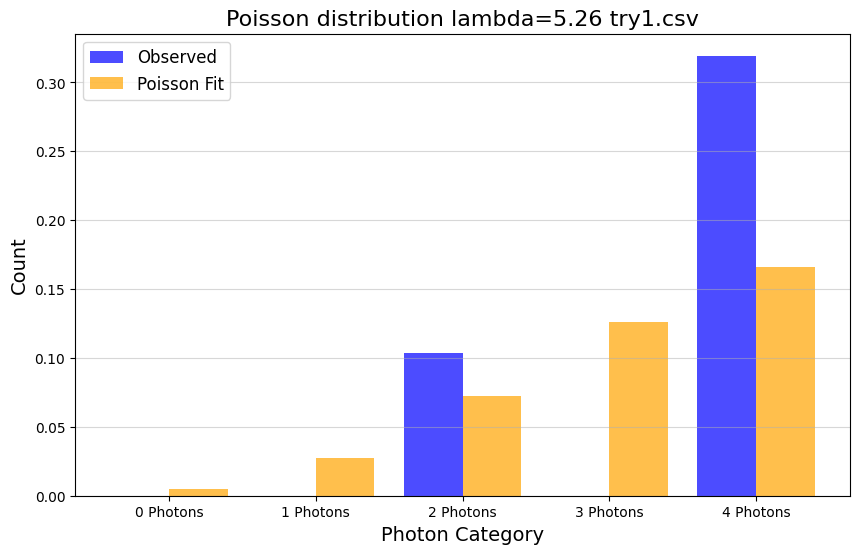

Fitted lambda (mean photon count): 5.256


In [41]:
from scipy.optimize import nnls

def truncate_and_nnls(P, Q, k):
    """
    Truncate P to a k x k matrix and solve for S using non-negative least squares.

    Parameters:
    - P: Transition matrix (2D numpy array).
    - Q: Observed statistics vector (1D numpy array).
    - k: Size to truncate P to (integer).

    Returns:
    - Non-negative solution S for the truncated system.
    """
    # Truncate P to a k x k matrix
    P_truncated = P[:k, :k]
    Q_truncated = Q[:k]

    # Solve using NNLS
    S_truncated, _ = nnls(P_truncated, Q_truncated)

    return S_truncated

# Example usage
k = 5


#S_truncated_nnls = truncate_and_nnls(avg_p_matrix, probabilities, k)

S_truncated_nnls = truncate_and_nnls(P_optimized, probabilities, k)

print(f"Truncated and Non-Negative S (size {k}):", S_truncated_nnls)


# Define a function for Poisson fitting
def poisson_scaled(k, lamb):
    """Poisson PMF scaled to match the observed total count."""
    return poisson.pmf(k, lamb)

# Fit the Poisson distribution to the observed counts
popt, _ = curve_fit(poisson_scaled, categories, S_truncated_nnls , p0=[0.3])  # Initial guess for lambda=1
fitted_lambda = popt[0]

# Generate the fitted Poisson counts
poisson_fit_counts = poisson_scaled(categories, fitted_lambda)

# Plot the histogram and Poisson fit
plt.figure(figsize=(10, 6))

# Observed counts
plt.bar(categories - 0.2, S_truncated_nnls , width=0.4, label='Observed', color='blue', alpha=0.7)

# Poisson fit
plt.bar(categories + 0.2, poisson_fit_counts, width=0.4, label='Poisson Fit', color='orange', alpha=0.7)

# Customize the plot
plt.title(f'Poisson distribution lambda={fitted_lambda:.2f} {file_path}', fontsize=16)
plt.xlabel('Photon Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(categories, [f'{c} Photons' for c in categories])
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.5)


# Save the figure
output_figure_path = f"./optimized_P/photon_classification_poisson_fit_{file_name}.png"  # Define the file name for saving the figure
plt.savefig(output_figure_path, dpi=300, bbox_inches='tight')  # Save with high resolution and tight layout
print(f"Figure saved to {output_figure_path}")

# Show the plot
plt.show()

# Print the fitted lambda
print(f"Fitted lambda (mean photon count): {fitted_lambda:.3f}")




In [42]:
import numpy as np
import os

# Path to the folder containing the CSV files
csv_folder = "optimized_P"  # Replace with your actual folder path

# List all CSV files in the folder
csv_files = [os.path.join(csv_folder, file) for file in os.listdir(csv_folder) if file.endswith('.csv')]

# Ensure there are files to process
if not csv_files:
    print("No CSV files found in the specified folder.")
else:
    # Initialize a list to store all P matrices
    matrices = []

    # Load each matrix from the provided CSV files
    for file in csv_files:
        matrix = np.loadtxt(file, delimiter=',')  # Read the matrix from the file
        matrices.append(matrix)

    # Convert the list of matrices into a 3D numpy array
    stacked_matrices = np.stack(matrices)

    # Calculate the average along the first axis
    avg_p_matrix = np.average(stacked_matrices, axis=0)
    std_p_matrix = np.std(stacked_matrices, axis=0)

    # Save the average P matrix to a new CSV file
    output_file = os.path.join(csv_folder, "average_P_matrix.csv")
    np.savetxt(output_file, avg_p_matrix, delimiter=',', fmt='%0.6f')
    output_file = os.path.join(csv_folder, "std_P_matrix.csv")
    np.savetxt(output_file, std_p_matrix, delimiter=',', fmt='%0.6f')
    print(f"Average P matrix saved to {output_file}")

    # Print the average P matrix
    print("Average P matrix:\n", avg_p_matrix)


Average P matrix saved to optimized_P\std_P_matrix.csv
Average P matrix:
 [[9.34089077e-01 1.08749538e-01 8.50120769e-02 3.30285385e-02
  2.72107692e-03 6.01461538e-04 2.00692308e-04 9.73846154e-05
  6.06923077e-05 4.00000000e-05]
 [0.00000000e+00 7.77742000e-01 5.16207462e-01 3.91070923e-01
  3.78290154e-01 4.24638000e-01 5.27704231e-01 6.89265077e-01
  9.19849615e-01 1.23852746e+00]
 [0.00000000e+00 0.00000000e+00 4.13021000e-01 5.62048154e-01
  5.80336769e-01 5.57488923e-01 5.21348692e-01 4.80771769e-01
  4.41485154e-01 4.04792615e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 2.87359462e-01
  2.32245308e-01 2.49666154e-01 2.89691692e-01 3.29861308e-01
  3.64070769e-01 3.92137154e-01]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  7.76116923e-02 3.31346154e-02 2.85583846e-02 3.68531538e-02
  4.90270769e-02 6.59120000e-02]]


Truncated and Non-Negative S (size 5): [0.         1.20711779 0.         0.         0.04336237]
Figure saved to ./optimized_P/photon_classification_poisson_fit_try1.csv.png


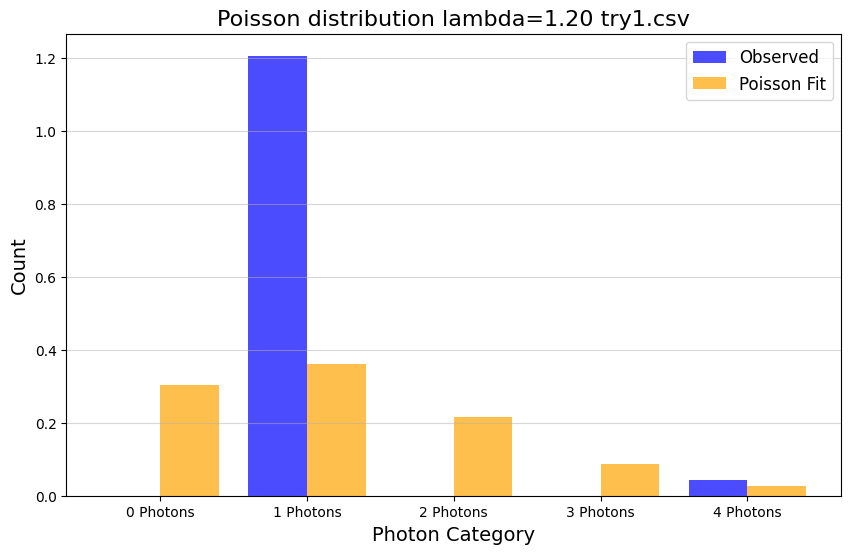

Fitted lambda (mean photon count): 1.195


In [43]:
from scipy.optimize import nnls

def truncate_and_nnls(P, Q, k):
    """
    Truncate P to a k x k matrix and solve for S using non-negative least squares.

    Parameters:
    - P: Transition matrix (2D numpy array).
    - Q: Observed statistics vector (1D numpy array).
    - k: Size to truncate P to (integer).

    Returns:
    - Non-negative solution S for the truncated system.
    """
    # Truncate P to a k x k matrix
    P_truncated = P[:k, :k]
    Q_truncated = Q[:k]

    # Solve using NNLS
    S_truncated, _ = nnls(P_truncated, Q_truncated)

    return S_truncated

# Example usage
k = 5


#S_truncated_nnls = truncate_and_nnls(avg_p_matrix, probabilities, k)

S_truncated_nnls = truncate_and_nnls(avg_p_matrix, probabilities, k)

print(f"Truncated and Non-Negative S (size {k}):", S_truncated_nnls)


# Define a function for Poisson fitting
def poisson_scaled(k, lamb):
    """Poisson PMF scaled to match the observed total count."""
    return poisson.pmf(k, lamb)

# Fit the Poisson distribution to the observed counts
popt, _ = curve_fit(poisson_scaled, categories, S_truncated_nnls , p0=[0.3])  # Initial guess for lambda=1
fitted_lambda = popt[0]

# Generate the fitted Poisson counts
poisson_fit_counts = poisson_scaled(categories, fitted_lambda)

# Plot the histogram and Poisson fit
plt.figure(figsize=(10, 6))

# Observed counts
plt.bar(categories - 0.2, S_truncated_nnls , width=0.4, label='Observed', color='blue', alpha=0.7)

# Poisson fit
plt.bar(categories + 0.2, poisson_fit_counts, width=0.4, label='Poisson Fit', color='orange', alpha=0.7)

# Customize the plot
plt.title(f'Poisson distribution lambda={fitted_lambda:.2f} {file_path}', fontsize=16)
plt.xlabel('Photon Category', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(categories, [f'{c} Photons' for c in categories])
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.5)


# Save the figure
output_figure_path = f"./optimized_P/photon_classification_poisson_fit_{file_path}.png"  # Define the file name for saving the figure
plt.savefig(output_figure_path, dpi=300, bbox_inches='tight')  # Save with high resolution and tight layout
print(f"Figure saved to {output_figure_path}")

# Show the plot
plt.show()

# Print the fitted lambda
print(f"Fitted lambda (mean photon count): {fitted_lambda:.3f}")


